In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
from seminartools.models.utils import get_mse_by_country
from seminartools.data import read_merged
from seminartools.models.four_quarter_average_model import FourQuarterAverageModel
from seminartools.models.pca_var_model import PCAVARModel
from seminartools.models.armax_model import ARMAXModel
from seminartools.models.uc_sv_ss_model import UCSVSSModel
from seminartools.models.random_effects_model import RandomEffectsModel
from seminartools.models.distance_model import DistanceModel
from seminartools.models.mucsvss_model import MUCSVSSModel

muc_model = MUCSVSSModel(num_particles=100008, stochastic_seasonality=True)
muc_model.load_from_disk("../../models/mucsvss_model_100008_deterministic_all.pkl")
muc_model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pycountry/db.py:51: UserWarning: Country's official_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pycountry/db.py:51: UserWarning: Country's common_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)


# 1. Read data

In [3]:
df = read_merged().reset_index()
df

country       date  inflation  gdp_growth  interest_rate  \
0             Japan 1977-01-01   0.022951    2.187257       6.333333   
1            Canada 1977-01-01   0.023904    1.533830       8.166667   
2     United States 1977-01-01   0.017231    1.186233       4.700000   
3             Japan 1977-04-01   0.027244    0.703788       5.000000   
4            Canada 1977-04-01   0.023346    0.510302       7.666667   
...             ...        ...        ...         ...            ...   
2166          Italy 2023-01-01   0.003938    0.552944       3.000000   
2167         Canada 2023-01-01   0.006080    0.610026       4.500000   
2168         Sweden 2023-01-01   0.014955    0.656897       2.833333   
2169          Korea 2023-01-01   0.010538    0.329875       3.500000   
2170   South Africa 2023-01-01   0.011202    0.406619       7.416667   

      unemployment_rate  commodity_CRUDE_PETRO  commodity_iNATGAS  \
0                   2.3                0.00000           0.052425   
1                   8.8                0.00000           0.052425   
2                   8.2                0.00000           0.052425   
3                   2.0               -0.00400           0.043586   
4                   8.0               -0.00400           0.043586   
...                 ...                    ...                ...   
2166                8.3               -0.02041          -0.585458   
2167                5.4               -0.02041          -0.585458   
2168                7.8               -0.02041          -0.585458   
2169                3.2               -0.02041          -0.585458   
2170               28.1               -0.02041          -0.585458   

      commodity_iAGRICULTURE  commodity_iMETMIN  commodity_iPRECIOUSMET  
0                   0.144757           0.041940                0.112740  
1                   0.144757           0.041940                0.112740  
2                   0.144757           0.041940                0.112740  
3                  -0.066688          -0.045412               -0.060029  
4                  -0.066688          -0.045412               -0.060029  
...                      ...                ...                     ...  
2166                0.002037           0.007418                0.043183  
2167                0.002037           0.007418                0.043183  
2168                0.002037           0.007418                0.043183  
2169                0.002037           0.007418                0.043183  
2170                0.002037           0.007418                0.043183  

[2171 rows x 11 columns]

In [4]:
# expanding window crossval
from seminartools.time_series_split import ExpandingWindowSplit

tss = ExpandingWindowSplit(start_date = "2000-01-01")
tss

# 2. Get stats (in percentage points)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/matthy/Desktop/IBEOR/third_year/seminar_forecasting/Bayesian/seminar-1/seminartools/models/armax_model.py:211: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast += exog_coefs[j] * exogData[i-1]
/Users/matthy/Desktop/IBEOR/third_year/seminar_forecasting/Bayesian/seminar-1/seminartools/models/armax_model.py:211: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

KeyboardInterrupt: 

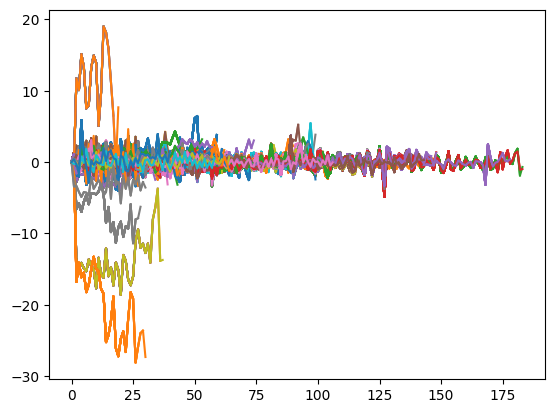

In [6]:
from seminartools.models.utils import get_mse_by_country
exog_columns = [
    "gdp_growth",
    "interest_rate",
    "unemployment_rate",
    "commodity_CRUDE_PETRO",
    "commodity_iNATGAS",
    "commodity_iAGRICULTURE",
    "commodity_iMETMIN",
    "commodity_iPRECIOUSMET",
]

stats = get_mse_by_country(
    [
        ("4qa", lambda: FourQuarterAverageModel()),
        ("ar", lambda: ARMAXModel(max_p=2, max_q=0)),
        ("arx", lambda: ARMAXModel(max_p=2, max_q=0, exogenous_columns=exog_columns)),
        ("arma", lambda: ARMAXModel(max_p=2, max_q=2)),
        ("armax", lambda: ARMAXModel(max_p=2, max_q=2, exogenous_columns = exog_columns)),
        ("pca_var", lambda: PCAVARModel()),
        ("uc_sv", lambda: UCSVSSModel(num_particles=10000, stochastic_seasonality=False)),
        ("uc_sv_ss",lambda: UCSVSSModel(num_particles=10000, stochastic_seasonality=True)),
        ("random_effects", lambda: RandomEffectsModel()),
        ("random_effects_x",lambda: RandomEffectsModel(exogenous_columns=exog_columns)),
        ("distance", lambda: DistanceModel()),
        ("distance_x", lambda: DistanceModel(exogenous_columns=exog_columns)),
        ("mucsvss", lambda: muc_model),

    ],
    df,
    tss,
    num_cores_parallel_models=1,  # only 1 model at once because models use joblib internally and nested joblib gives issues
)
stats

# 3. Plot the Data

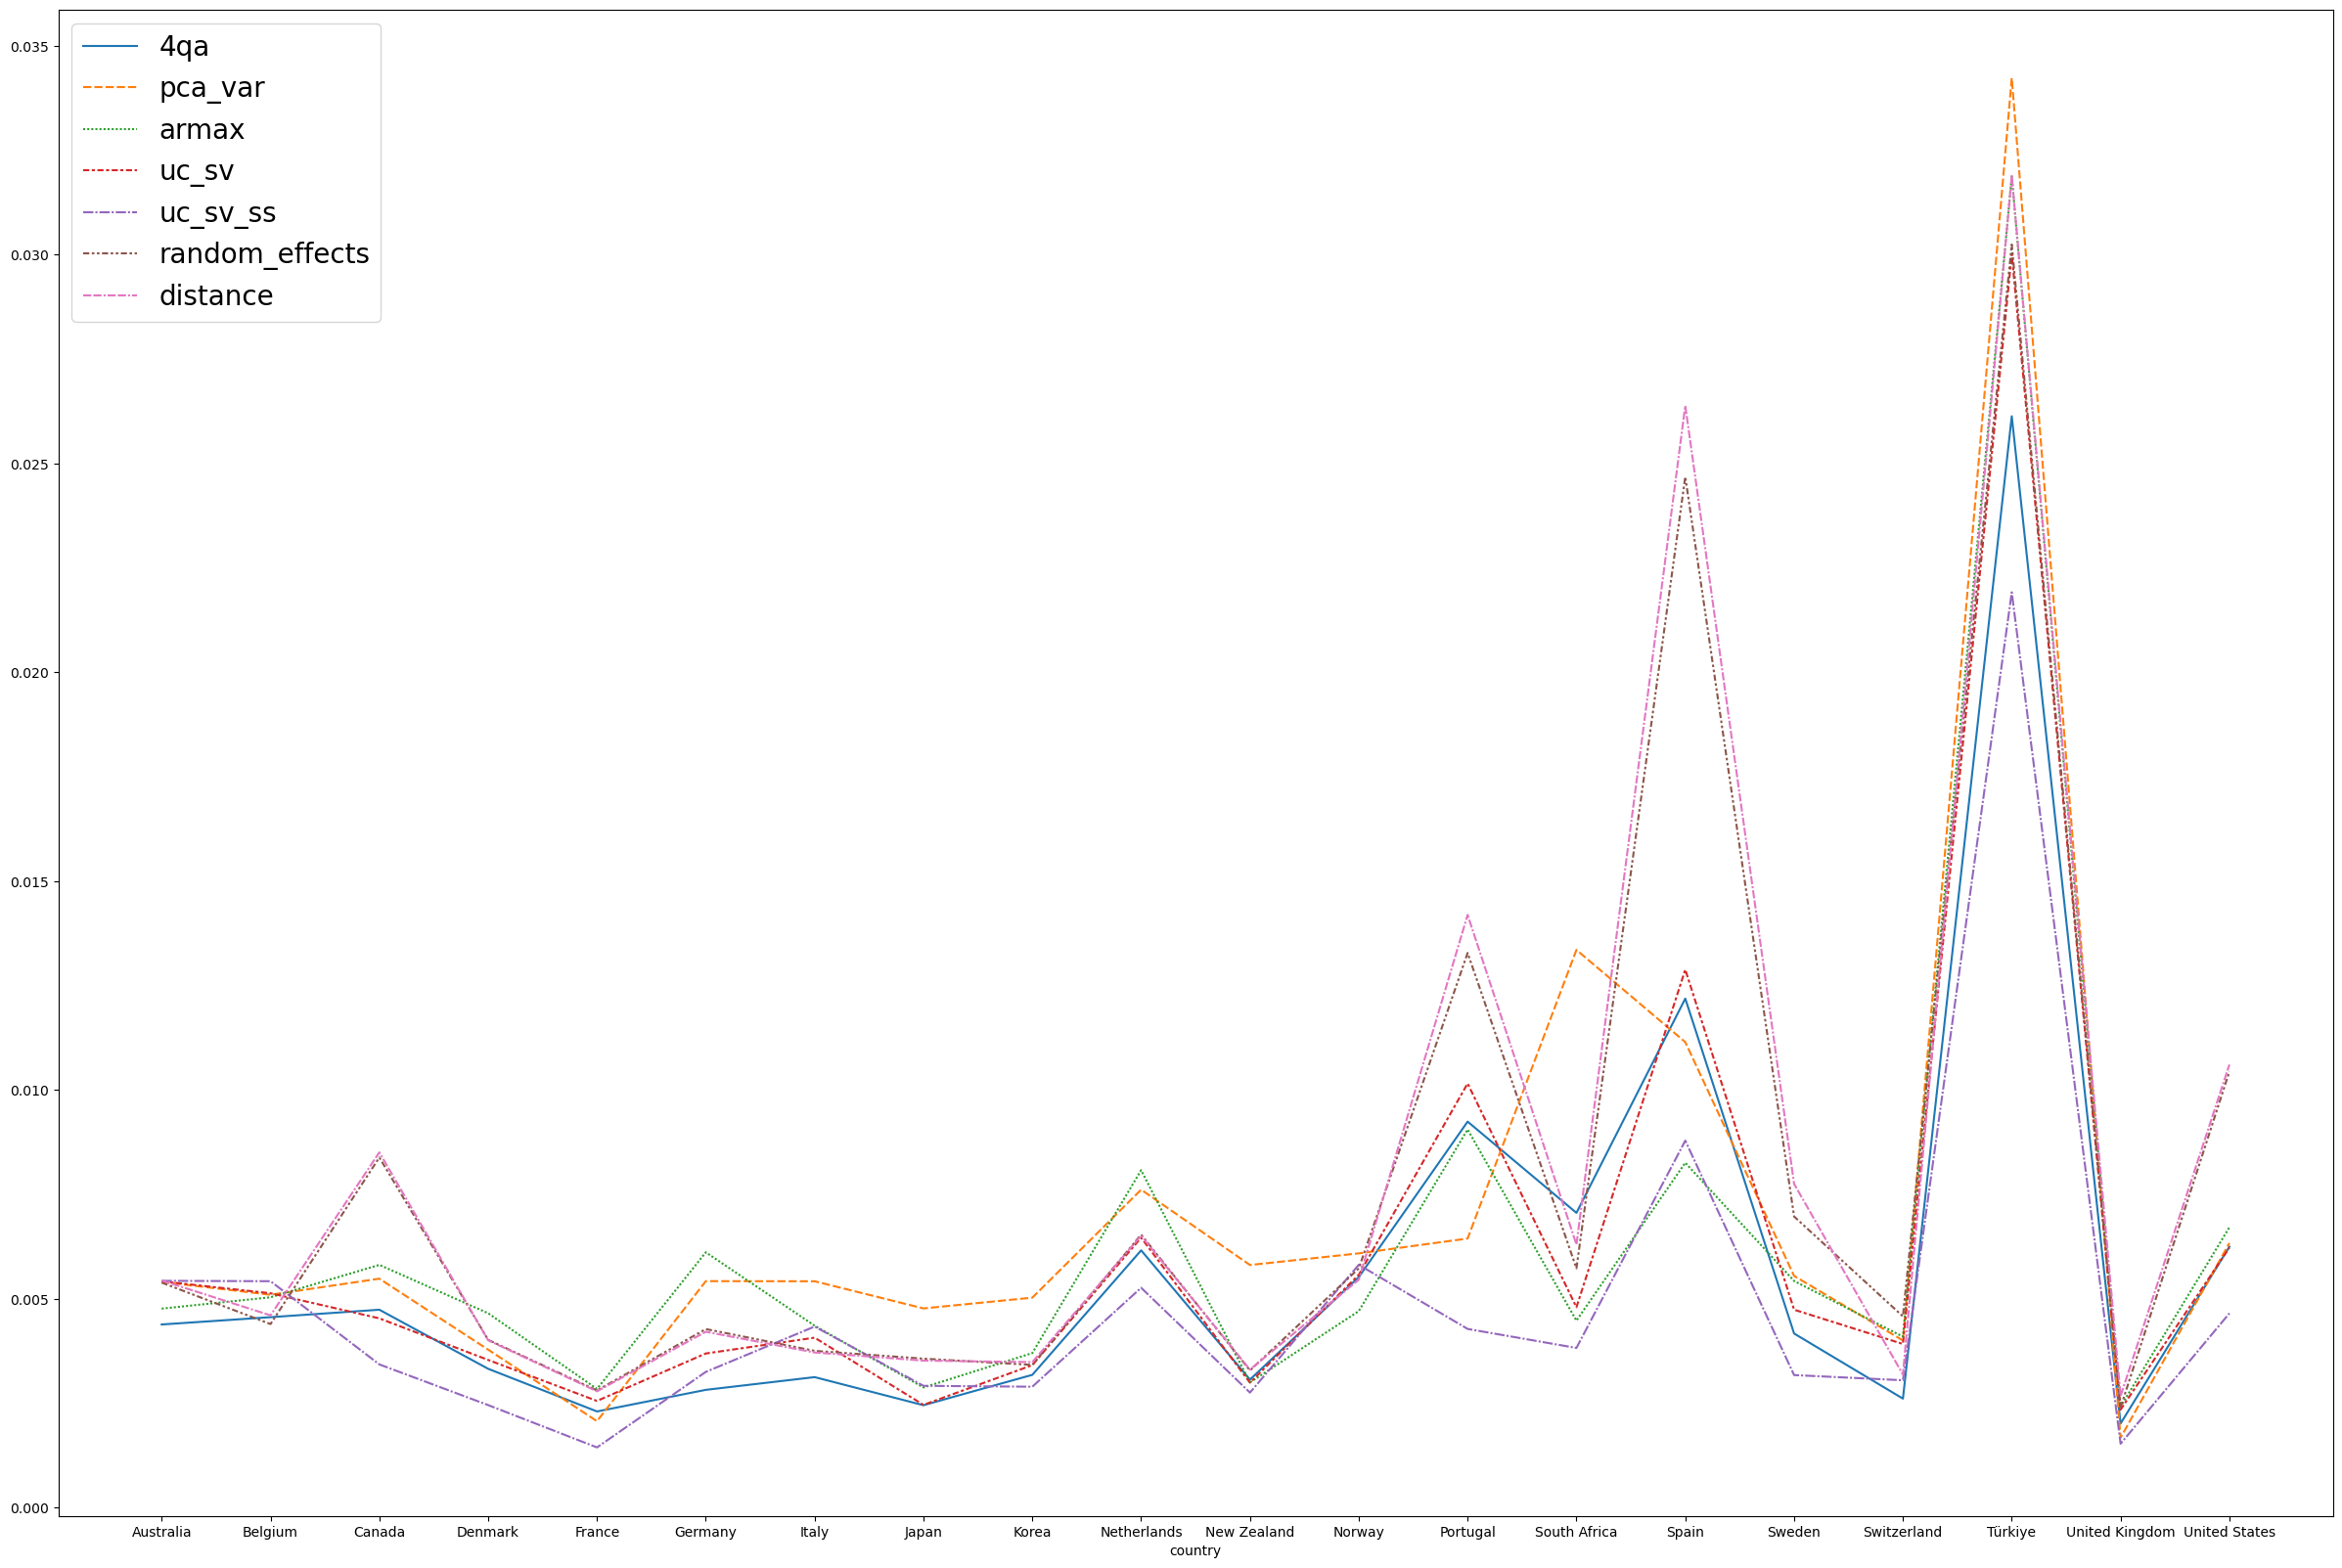

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(30,20))
sns.lineplot(
    data = stats
)
plt.legend(loc = 'upper left', fontsize = "20")


# 4. Play around with sets of exogenous variables for VARX

In [39]:
from seminartools.models.utils import get_mse_by_country
from seminartools.data import read_merged

In [40]:
df = read_merged().reset_index()
# expanding window crossval
from seminartools.time_series_split import ExpandingWindowSplit

tss = ExpandingWindowSplit(start_date = "2000-01-01")
df

c:\users\vandi\onedrive\documenten\github\seminar\seminartools\data.py:161: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample("Q").apply(lambda x: (1 + x).prod() - 1)  # quarterly return
c:\users\vandi\onedrive\documenten\github\seminar\seminartools\data.py:397: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample("Q").mean()  # Mean interest rate


country       date  inflation  gdp_growth  interest_rate  \
0             Japan 1977-01-01   0.022951    2.187257       6.333333   
1            Canada 1977-01-01   0.023904    1.533830       8.166667   
2     United States 1977-01-01   0.017231    1.186233       4.700000   
3             Japan 1977-04-01   0.027244    0.703788       5.000000   
4            Canada 1977-04-01   0.023346    0.510302       7.666667   
...             ...        ...        ...         ...            ...   
2166          Italy 2023-01-01   0.003938    0.552944       3.000000   
2167         Canada 2023-01-01   0.006080    0.610026       4.500000   
2168         Sweden 2023-01-01   0.014955    0.656897       2.833333   
2169          Korea 2023-01-01   0.010538    0.329875       3.500000   
2170   South Africa 2023-01-01   0.011202    0.406619       7.416667   

      unemployment_rate  commodity_CRUDE_PETRO  commodity_iNATGAS  \
0                   2.3                0.00000           0.052425   
1                   8.8                0.00000           0.052425   
2                   8.2                0.00000           0.052425   
3                   2.0               -0.00400           0.043586   
4                   8.0               -0.00400           0.043586   
...                 ...                    ...                ...   
2166                8.3               -0.02041          -0.585458   
2167                5.4               -0.02041          -0.585458   
2168                7.8               -0.02041          -0.585458   
2169                3.2               -0.02041          -0.585458   
2170               28.1               -0.02041          -0.585458   

      commodity_iAGRICULTURE  commodity_iMETMIN  commodity_iPRECIOUSMET  
0                   0.144757           0.041940                0.112740  
1                   0.144757           0.041940                0.112740  
2                   0.144757           0.041940                0.112740  
3                  -0.066688          -0.045412               -0.060029  
4                  -0.066688          -0.045412               -0.060029  
...                      ...                ...                     ...  
2166                0.002037           0.007418                0.043183  
2167                0.002037           0.007418                0.043183  
2168                0.002037           0.007418                0.043183  
2169                0.002037           0.007418                0.043183  
2170                0.002037           0.007418                0.043183  

[2171 rows x 11 columns]

c:\Users\vandi\AppData\Local\anaconda3\envs\py311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\vandi\AppData\Local\anaconda3\envs\py311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\vandi\AppData\Local\anaconda3\envs\py311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\vandi\AppData\Local\anaconda3\envs\py311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-inverti

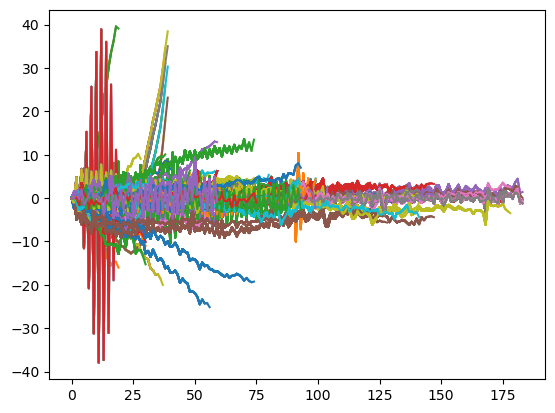

In [41]:
from seminartools.models.armax_model import ARMAXModel
stats = get_mse_by_country(
    [
        
        ("nothing", lambda: ARMAXModel(max_p=2, max_q=2)),
        (
            "gdp_growth",
            lambda: ARMAXModel(max_p=2, max_q=2, exogenous_columns=["gdp_growth"]),
        ),
        (
            "interest_rate",
            lambda: ARMAXModel(max_p=2, max_q=2, exogenous_columns= ["interest_rate"]),
        ),
        (
            "commo",
            lambda: ARMAXModel(max_p=2, max_q=2, exogenous_columns= ["commodity_CRUDE_PETRO"]),
        ),
        (
            "unem",
            lambda: ARMAXModel(max_p=2, max_q=2, exogenous_columns= ["unemployment_rate"]),
        ),
        
    ],
    df,
    tss,
    num_cores_parallel_models=1,  # only 1 model at once because models use joblib internally and nested joblib gives issues
)

In [42]:
stats

nothing  gdp_growth  interest_rate     commo      unem
country                                                                
Australia       0.004289    0.004249       0.011517  0.004234  0.037161
Belgium         0.007357    0.008083       0.107039  0.009393  0.005962
Canada          0.004714    0.004926       0.030422  0.004537  0.004845
Denmark         0.004887    0.035397       0.174788  0.007191  0.005169
France          0.007198    0.013605       0.008887  0.004844  0.017496
Germany         0.005645    0.005871       0.006890  0.010243  0.005966
Italy           0.004516    0.006055       0.029788  0.005102  0.005227
Japan           0.002632    0.002767       0.056030  0.002919  0.112457
Korea           0.008390    0.023647       0.014030  0.028156  0.231367
Netherlands     0.007059    0.007867       0.341624  0.021858  0.010709
New Zealand     0.002893    0.003368       0.004132  0.002680  0.044689
Norway          0.009067    0.012566       0.066106  0.010069  1.373151
Portugal        0.006001    0.008191       0.006625  0.033062  0.006819
South Africa    0.008423    0.093477       0.701753  0.157485  0.010092
Spain           0.006370    0.034632       0.006204  0.006610  0.007133
Sweden          0.004301    0.088402       0.036299  0.012616  0.004857
Switzerland     0.004096    0.028652       0.083371  0.003276  0.012171
Türkiye         0.156918    0.167006       0.296357  0.158928  0.173994
United Kingdom  0.305610    0.016884       0.637039  0.816972  0.428412
United States   0.005078    0.005727       0.013684  0.004722  0.005425

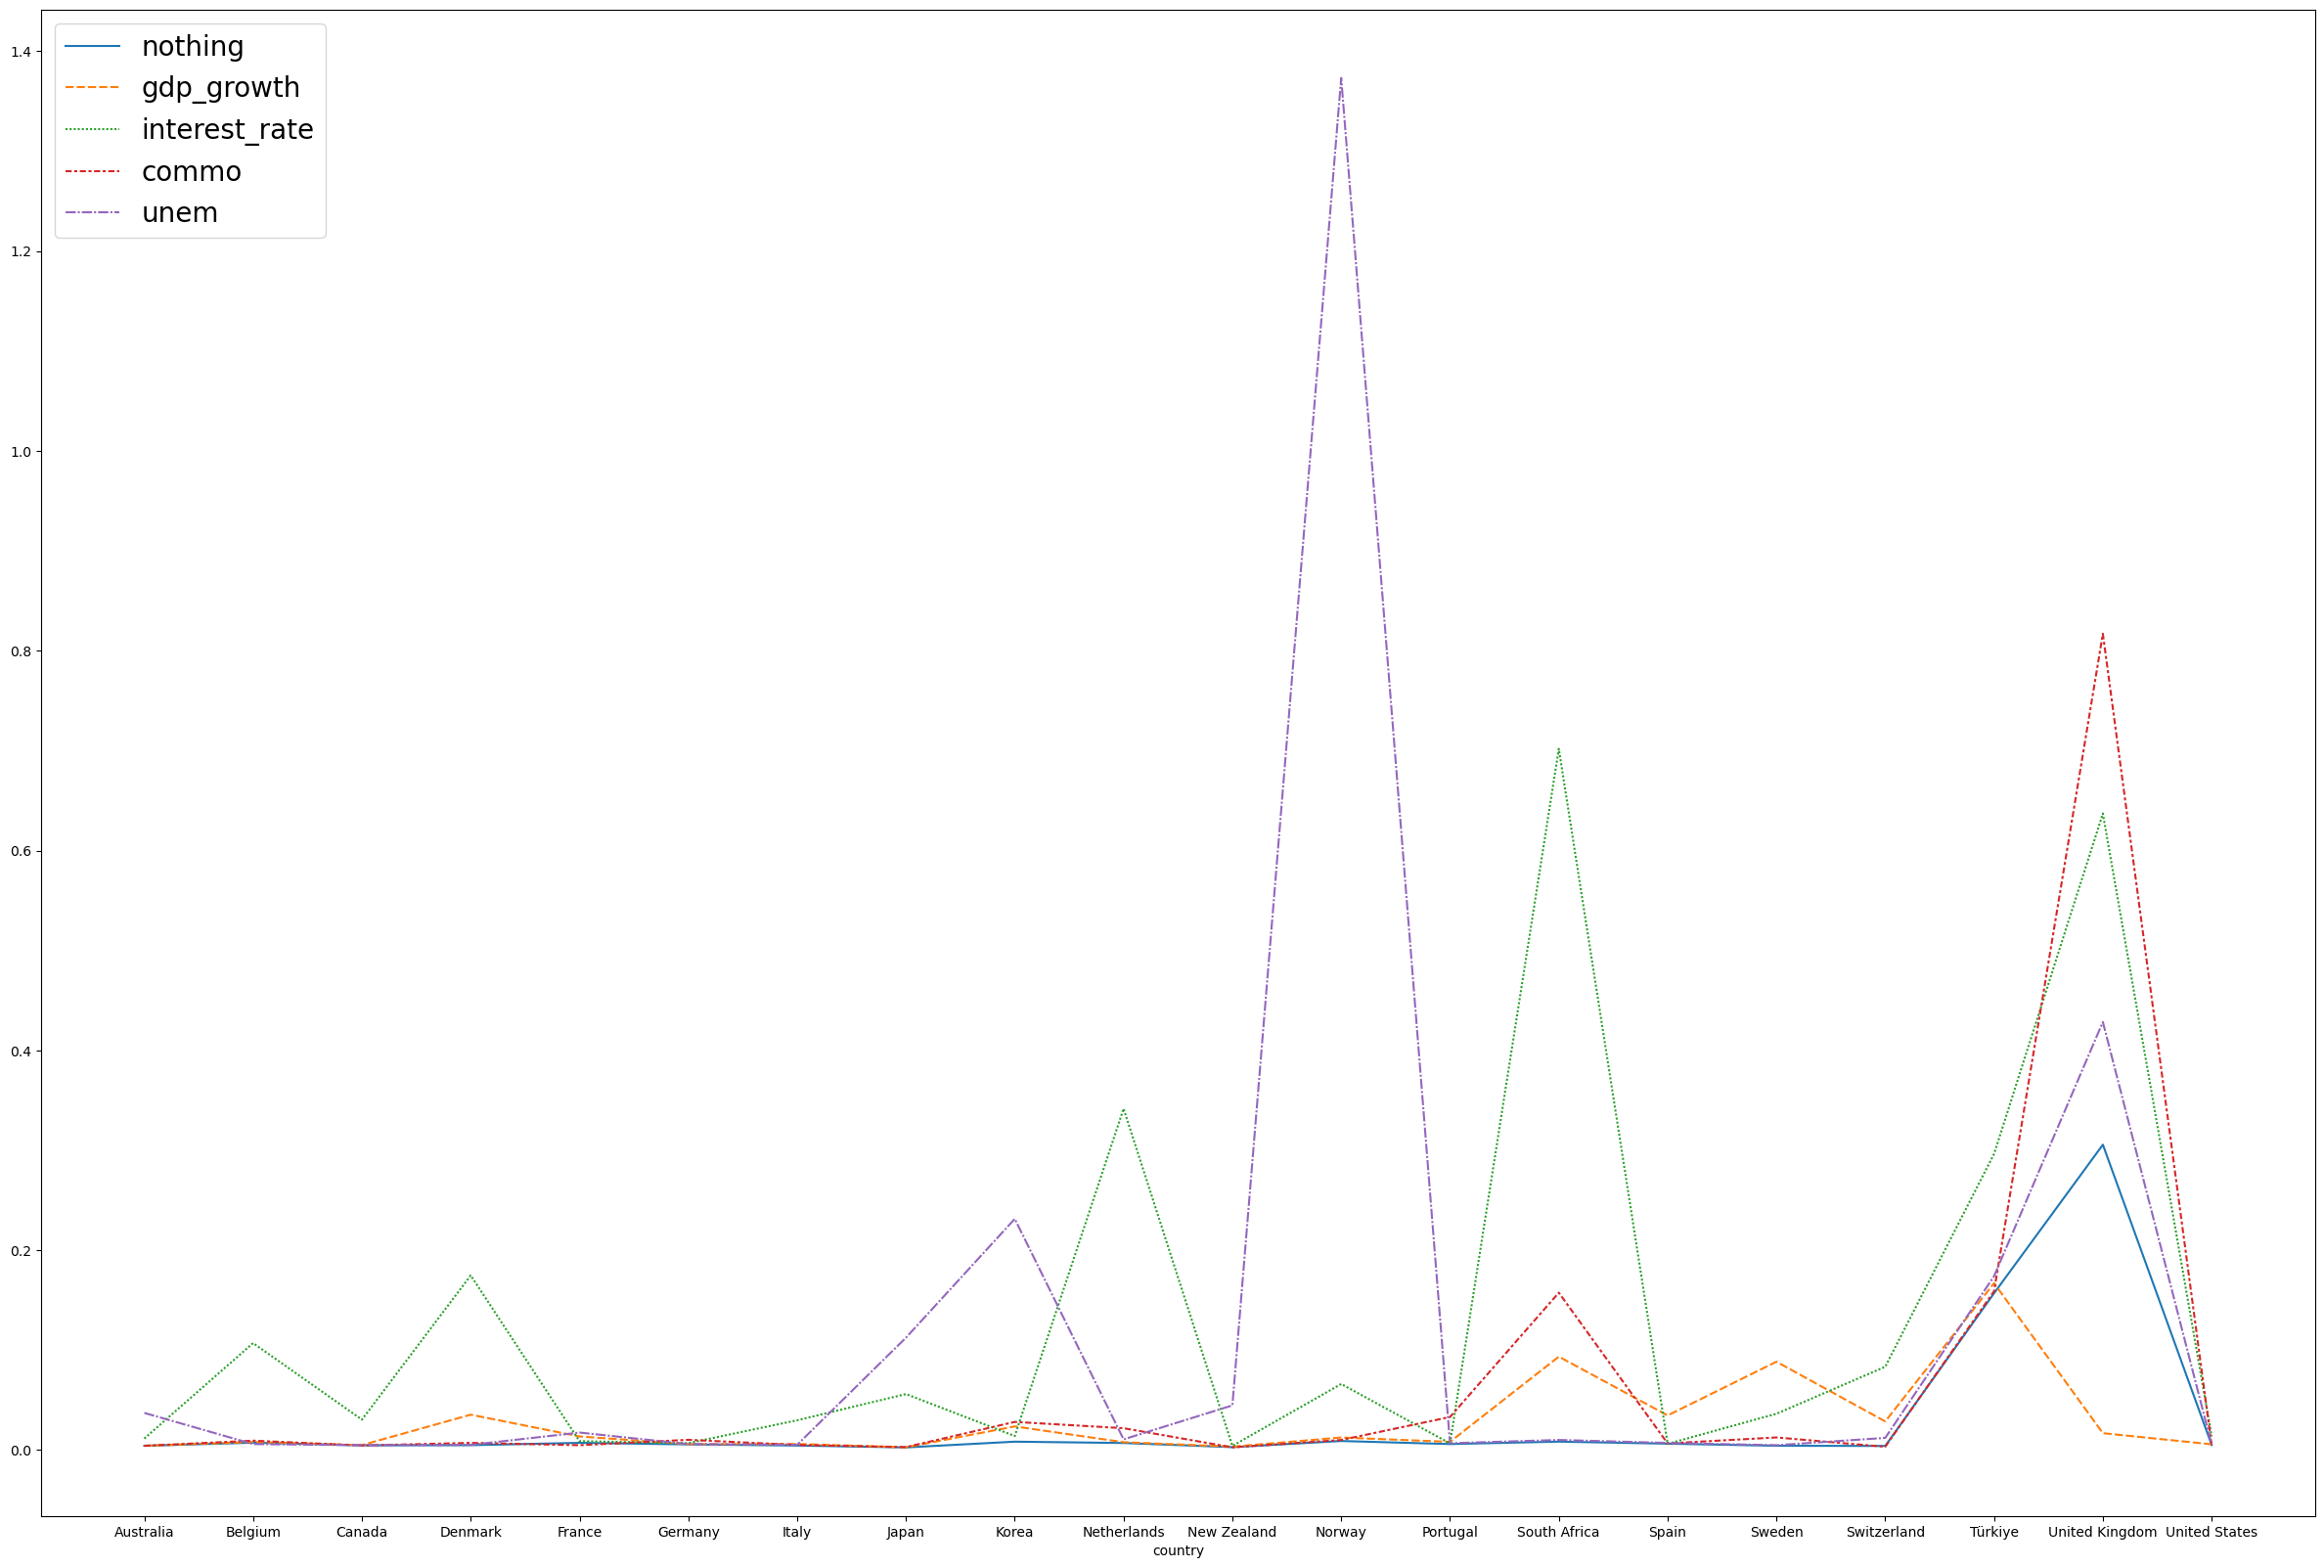

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
#data=stats.drop(["Norway", "United Kingdom"], axis=0)
plt.figure(figsize=(30,20))
sns.lineplot(
    data = stats
)
plt.legend(loc = 'upper left', fontsize = "20")

Note that unemployment performance especially bad for norway, interest rates for south africa, and everything apart from gdp growth performs poorly for the UK. However, if you remove those from the sample, 'nothing' still performs best

In [44]:
data = stats.drop(["Norway", "United Kingdom", "South Africa"], axis=0)
print(stats.mean())
print(data.mean())


nothing          0.028272
gdp_growth       0.028569
interest_rate    0.131629
commo            0.065245
unem             0.125155
dtype: float64
nothing          0.014256
gdp_growth       0.026379
interest_rate    0.072217
commo            0.018845
unem             0.040673
dtype: float64


c:\users\vandi\onedrive\documenten\github\seminar\seminartools\data.py:161: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample("Q").apply(lambda x: (1 + x).prod() - 1)  # quarterly return
c:\users\vandi\onedrive\documenten\github\seminar\seminartools\data.py:397: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample("Q").mean()  # Mean interest rate
c:\Users\vandi\AppData\Local\anaconda3\envs\py311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\vandi\AppData\Local\anaconda3\envs\py311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\vandi\Ap

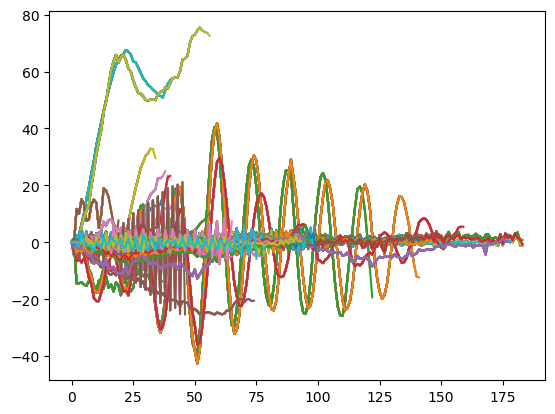

In [45]:
from seminartools.models.armax_model import ARMAXModel
df = read_merged(remove_countries= ["Türkiye"]).reset_index()

exog_columns = [
    "gdp_growth",
    "interest_rate",
    "unemployment_rate",
    "commodity_CRUDE_PETRO",
    "commodity_iNATGAS",
    "commodity_iAGRICULTURE",
    "commodity_iMETMIN",
    "commodity_iPRECIOUSMET",
]

stats2 = get_mse_by_country(
    [
        
        ("nothing", lambda: ARMAXModel(max_p=2, max_q=2)),
        (
            "all",
            lambda: ARMAXModel(max_p=2, max_q=2, exogenous_columns= exog_columns),
        ),
        
    ],
    df,
    tss,
    num_cores_parallel_models=1,  # only 1 model at once because models use joblib internally and nested joblib gives issues
)

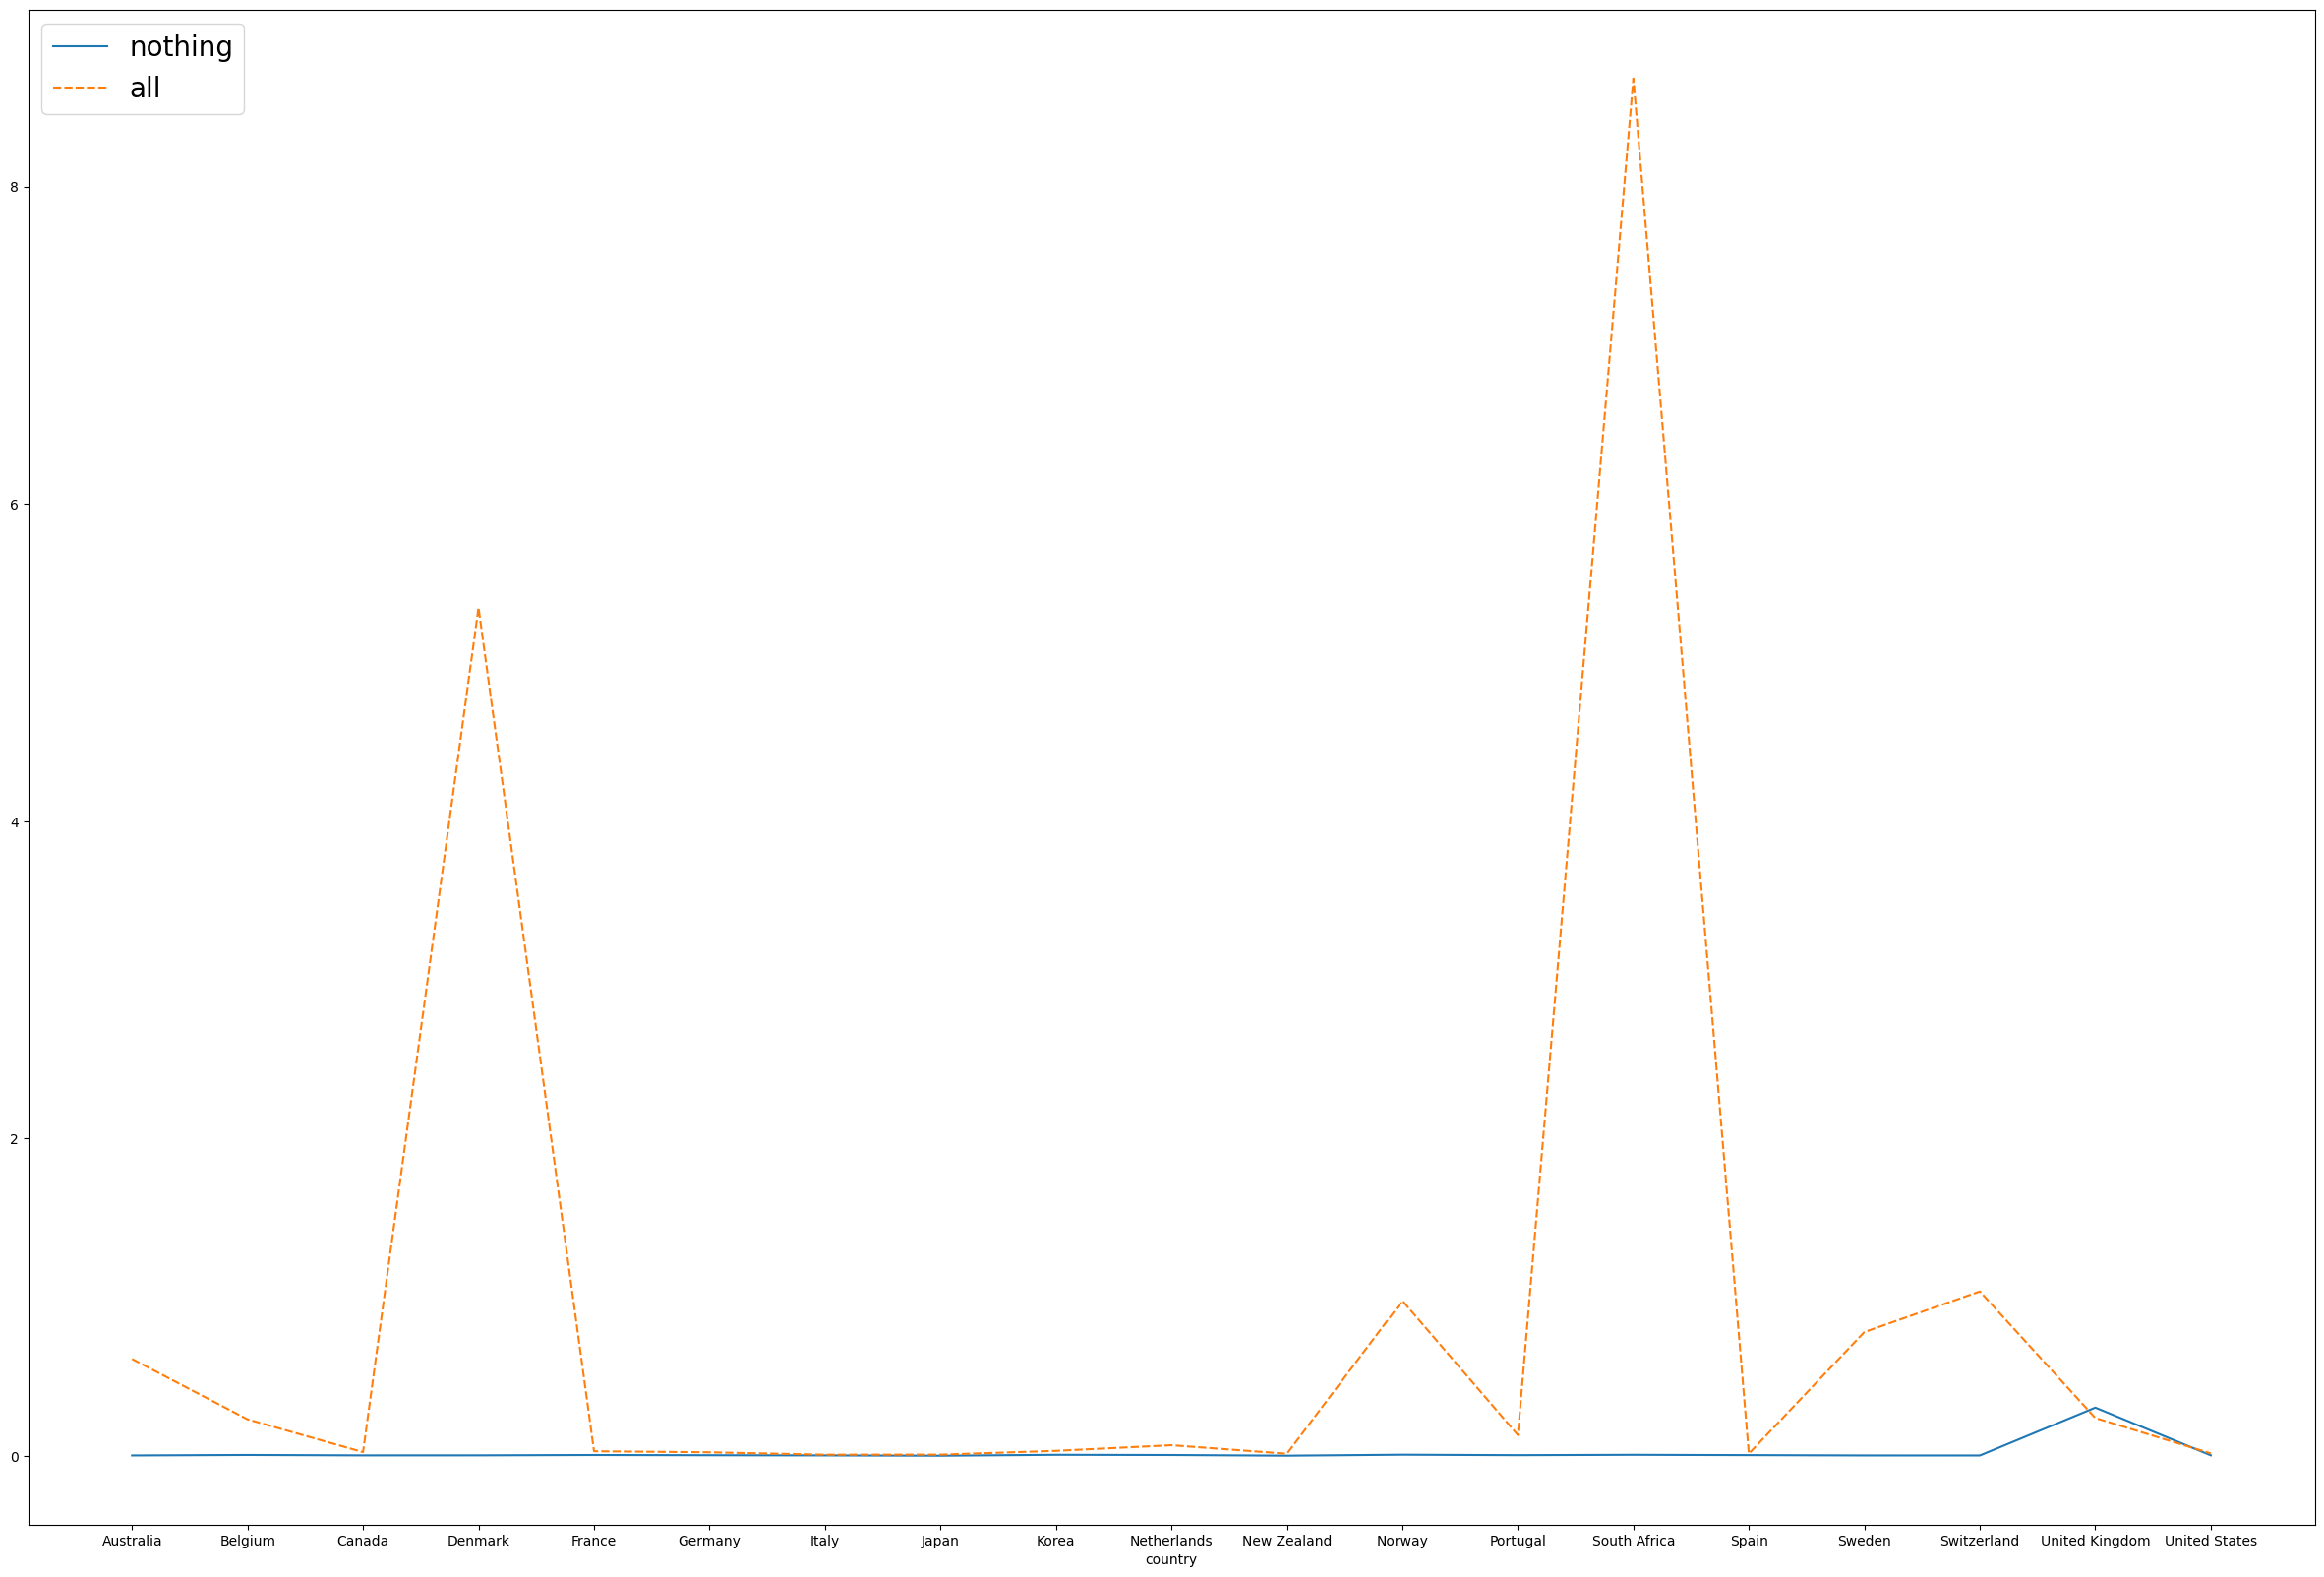

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(30,20))
sns.lineplot(
    data = stats2
)
plt.legend(loc = 'upper left', fontsize = "20")

In [48]:
stats2.mean()

nothing    0.021501
all        0.962741
dtype: float64